### Do the dirty things

- All NLP tasks starts with dirty cleaning work
- Tokenize things, determine vocab size, sequence lengths...
- After model training, you need to save tokenizer as well as the  model

In [2]:
# !pip install tensorflow_datasets
# !pip install -U 'tensorflow-text==2.8.*'

In [4]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

logging.getLogger('tensorflow').setLevel(logging.ERROR)

### Download Data

In [12]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True, data_dir = './tensorflow_data')
train_examples, val_examples = examples['train'], examples['validation']

In [28]:
print("*"*150)
for t in train_examples.take(3):
    print(t[0].numpy().decode())
    print(t[1].numpy().decode())
    print("*"*150)

******************************************************************************************************************************************************
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
******************************************************************************************************************************************************
mas e se estes fatores fossem ativos ?
but what if it were active ?
******************************************************************************************************************************************************
mas eles não tinham a curiosidade de me testar .
but they did n't test for curiosity .
******************************************************************************************************************************************************


### Download Tokenizer

In [38]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load(model_name)

### 研究一下这个tokenizer

In [70]:
import inspect
from typing import Callable

def inspect_object(obj, filter_private = True):

    filter_ = lambda x:not x.startswith('_') if filter_private \
                else lambda x:True

    return {m: 'callable' if isinstance(getattr(obj,m), Callable) else 'attribute'
            for m in dir(obj) if filter_(m)}

In [73]:
inspect_object(tokenizers)

{'en': 'attribute',
 'graph_debug_info': 'attribute',
 'pt': 'attribute',
 'signatures': 'attribute',
 'tensorflow_git_version': 'attribute',
 'tensorflow_version': 'attribute'}

In [72]:
inspect_object(tokenizers.en)

{'detokenize': 'callable',
 'get_reserved_tokens': 'callable',
 'get_vocab_path': 'callable',
 'get_vocab_size': 'callable',
 'lookup': 'callable',
 'tokenize': 'callable',
 'tokenizer': 'attribute',
 'vocab': 'attribute'}

### Use tokenizer


这俩很nice的东西，直接帮我把输入和输入都变成想要的样子了
- `tokenizers.lang.tokenize(tensor)`
- `tokenizers.lang.detokenize(encoded_tensor)`
- `tokenizers.lang.lookup(encoded_tensor)`

In [113]:
pt, en = next(iter(train_examples.batch(10).take(1)))

In [114]:
tokenized_pt = tokenizers.pt.tokenize(pt)
tokenized_pt

<tf.RaggedTensor [[2, 44, 115, 6402, 148, 40, 887, 14, 3936, 40, 463, 2715, 94, 2047, 14, 84,
  44, 40, 117, 1328, 2721, 818, 539, 16, 3]                                 ,
 [2, 99, 44, 89, 199, 2836, 1336, 3996, 32, 3],
 [2, 99, 131, 88, 383, 40, 2673, 83, 110, 1972, 16, 3],
 [2, 44, 105, 5286, 7097, 2955, 3276, 44, 40, 407, 205, 267, 104, 14, 97,
  40, 961, 1113, 613, 14, 404, 186, 144, 1689, 16, 3]                    ,
 [2, 39, 39, 39, 39, 9, 9, 143, 283, 162, 128, 40, 1569, 100, 142, 420, 16,
  9, 9, 3]                                                                 ,
 [2, 39, 39, 104, 4877, 106, 464, 93, 39, 39, 9, 9, 3603, 83, 600, 9, 9, 9,
  9, 14, 84, 109, 1036, 84, 360, 92, 111, 4300, 15, 89, 3924, 99, 84, 14,
  103, 362, 14, 88, 360, 307, 16, 9, 9, 3]                                 ,
 [2, 5827, 15, 100, 140, 100, 860, 1190, 6405, 174, 83, 5197, 100, 6405,
  1700, 3145, 14, 98, 665, 220, 321, 40, 6634, 157, 91, 825, 102, 89, 6630,
  158, 133, 16, 3]                            

In [115]:
tokenizers.pt.detokenize(tokenized_pt)

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'e quando melhoramos a procura , tiramos a unica vantagem da impressao , que e a serendipidade .',
       b'mas e se estes fatores fossem ativos ?',
       b'mas eles nao tinham a curiosidade de me testar .',
       b'e esta rebeldia consciente e a razao pela qual eu , como agnostica , posso ainda ter fe .',
       b"` ` ` ` ' ' podem usar tudo sobre a mesa no meu corpo . ' '",
       b"` ` eu escrevo muito acerca do ` ` ' ' teatro de seguranca ' ' ' ' , que sao produtos que fazem as pessoas sentirem - se seguras mas que , na realidade , nao fazem nada . ' '",
       b'colocaram - no bem no fundo duma mina de ferro no minnesota , nos ultimos dois dias anunciaram os resultados mais sensiveis ate agora .',
       b'algumas pessoas tem medo de que nao gostem delas .',
       b'nao , o que nos aconteceu , chris , e que o poder , o preco esta fixado fora da margem .',
       b'de volta a minha pergunta : porque e que fiquei ?'], dtype=ob

In [116]:
tokenizers.pt.lookup(tokenized_pt)

<tf.RaggedTensor [[b'[START]', b'e', b'quando', b'melhora', b'##mos', b'a', b'procura', b',',
  b'tiramos', b'a', b'unica', b'vantagem', b'da', b'impressao', b',',
  b'que', b'e', b'a', b'ser', b'##en', b'##di', b'##p', b'##idade', b'.',
  b'[END]']                                                                 ,
 [b'[START]', b'mas', b'e', b'se', b'estes', b'fatores', b'fossem',
  b'ativos', b'?', b'[END]']                                       ,
 [b'[START]', b'mas', b'eles', b'nao', b'tinham', b'a', b'curiosidade',
  b'de', b'me', b'testar', b'.', b'[END]']                             ,
 [b'[START]', b'e', b'esta', b're', b'##bel', b'##dia', b'consciente', b'e',
  b'a', b'razao', b'pela', b'qual', b'eu', b',', b'como', b'a', b'##g',
  b'##nos', b'##tica', b',', b'posso', b'ainda', b'ter', b'fe', b'.',
  b'[END]']                                                                 ,
 [b'[START]', b'`', b'`', b'`', b'`', b"'", b"'", b'podem', b'usar',
  b'tudo', b'sobre', b'a', b'mesa', 

### Very stupid determined sequence length part

...................................................

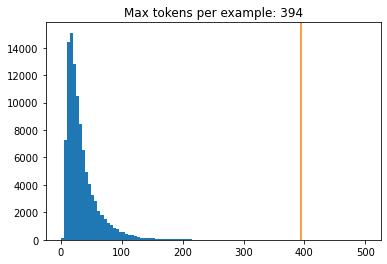

In [123]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');